In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import torch
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Embedding, Linear, Softmax, NLLLoss, RNN, ELU
from torch.optim import SGD

from torch.nn import MSELoss, L1Loss
from torch.optim import Adam

# Utils

In [3]:
def iter_batches(batch_size, train_in, train_out, shuffle=False):
    if shuffle:
        pass
    
    cur = 0
    batch_in, batch_out = train_in[cur:cur+batch_size], train_out[cur:cur+batch_size]
    yield batch_in, batch_out
    
    while batch_in.shape[0] == batch_size:
        cur += batch_size
        batch_in, batch_out = train_in[cur:cur+batch_size], train_out[cur:cur+batch_size]
        if batch_in.numel() > 0:
            yield batch_in, batch_out

# Data

In [4]:
val = 1
ind = 0
def val_in_seq(data):
    return torch.tensor([val in seq for seq in data]).unsqueeze(1).float()

def val_at_index(data):
    return (data[:, ind] == val).unsqueeze(1).float()


def is_sorted(data):
    return ((X.sort(1).values == X).sum(1) == X.shape[1]).unsqueeze(1).float()

def sum_of_seq(data):
    return data.sum(1).unsqueeze(1).float()


task_function = sum_of_seq    

In [5]:
n, k, V = 100, 3, 5
X = torch.randint(V, size=(n, k))
Ys = [sum_of_seq(X), val_in_seq(X)]

eval_X = torch.randint(V, size=(10, k))
eval_Ys = sum_of_seq(eval_X), val_in_seq(eval_X)


# Definitions

In [6]:
class LM(torch.nn.Module):
    def __init__(self, vocab_dim, embed_dim=4):
        super().__init__()
        
        self.vocab_dim = vocab_dim
        self.embed_dim = embed_dim
        self.emb = Embedding(vocab_dim, self.embed_dim)
        
        # nhead needs to divide d_model (embedding dimension)
        self.encoder_layer = TransformerEncoderLayer(d_model=self.embed_dim, nhead=self.embed_dim//2)
        self.encoder = TransformerEncoder(self.encoder_layer, num_layers=1)

        
    def forward(self, x):
        x_emb = self.emb(x)
        out = self.encoder(x_emb)
#         out_p = self.sigma(self.linear(out))
        return out  # output shape is (x.shape[0], x.shape[1], self.embed_dim)

In [7]:
class Head(torch.nn.Module):
    def __init__(self, lm, out_dim):
        super().__init__()
        self.lm = lm
        self.in_dim = lm.embed_dim
        self.out_dim = out_dim
        
        self.linear = Linear(in_features=self.in_dim, out_features=self.out_dim)
    
    def forward(self, lm_input):
        return self.linear(lm(lm_input))
    
    
class AggregateHead(Head):
    @staticmethod
    def aggr_sum(lm_output):
        # lm output shape:(batch, seq_len, transformer_dim)
        return lm_output.sum(1)
    
    @staticmethod
    def aggr_mean(lm_output):
        # lm output shape:(batch, seq_len, transformer_dim)
        return lm_output.mean(1)
    
    def __init__(self, lm, aggregate_function):
        super().__init__(lm, out_dim=1)
        
        self.aggr_f = aggregate_function
        from torch.nn import Identity
        self.final_layer = Identity()
        
    def forward(self, lm_input):
        lm_out = lm(lm_input)
        aggr = self.aggr_f(lm_out)
        return self.final_layer(self.linear(aggr))

In [8]:
class Hydra(torch.nn.Module):
    def __init__(self, *heads):
        self.heads = heads
        
    def forward(self, lm_input):
        return [h(lm_input) for h in self.heads]
    
    def step(self, lm_input, outputs, criteria):
        for  h, out, crit in zip(self.heads, outputs, criteria):
            pred = h(lm_input)
            yield crit(pred, out)
            
            
            
            
            
#         loss.backward()
#         opt.step()

# Instantiations

In [10]:
lm = LM(V, embed_dim=24)

sum_head = AggregateHead(lm, aggregate_function=AggregateHead.aggr_sum)
ind_head = AggregateHead(lm, aggregate_function=AggregateHead.aggr_sum)

hyd = Hydra(sum_head, ind_head)

losses = [[], []]

def put_lsss(lss_ls):
    for ls, l in zip(losses, lss_ls):
        ls.append(l.detach().item())


# Training

In [11]:
for m in hyd.heads: m.train()

crits = [MSELoss()]*2 # may be same object
optims = [Adam(sum_head.parameters(), lr=0.01),  Adam(ind_head.parameters(), lr=0.01)]

In [12]:
for _ in tqdm(range(1000)):
    for o in optims: o.zero_grad()


    cur_losses = list(hyd.step(X, Ys, crits))

    for l in cur_losses: l.backward()
    for o in optims: o.step()
        
    put_lsss(cur_losses)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/valentin/.local/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|██████████| 1000/1000 [00:26<00:00, 37.32it/s]


# Inspection

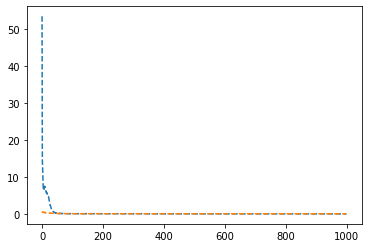

In [13]:
for ls in losses: plt.plot(range(len(ls)), ls, "--")

In [14]:
for h, eval_Y in zip(hyd.heads, eval_Ys):
    h.eval()
    print(eval_X, h(eval_X), eval_Y)
    print("\n")

tensor([[4, 3, 2],
        [3, 4, 0],
        [4, 2, 0],
        [2, 2, 0],
        [0, 2, 4],
        [2, 0, 0],
        [2, 1, 0],
        [4, 4, 2],
        [3, 1, 4],
        [2, 4, 1]]) tensor([[ 9.4089],
        [ 7.2998],
        [ 6.2285],
        [ 4.1321],
        [ 6.2313],
        [ 2.0262],
        [ 3.0542],
        [10.4499],
        [ 8.3304],
        [ 7.2749]], grad_fn=<AddmmBackward>) tensor([[ 9.],
        [ 7.],
        [ 6.],
        [ 4.],
        [ 6.],
        [ 2.],
        [ 3.],
        [10.],
        [ 8.],
        [ 7.]])


tensor([[4, 3, 2],
        [3, 4, 0],
        [4, 2, 0],
        [2, 2, 0],
        [0, 2, 4],
        [2, 0, 0],
        [2, 1, 0],
        [4, 4, 2],
        [3, 1, 4],
        [2, 4, 1]]) tensor([[0.2102],
        [0.1378],
        [0.1731],
        [0.1021],
        [0.1699],
        [0.0541],
        [0.7706],
        [0.3077],
        [0.8515],
        [0.8777]], grad_fn=<AddmmBackward>) tensor([[0.],
        [0.],
        [0.],
 

In [19]:
x = torch.tensor([10.], requires_grad=True)
x.backward()


print(x)

tensor([10.], requires_grad=True)
